## Course Dataset

In [1]:
import pandas as pd
import numpy as np
import time
import json
from pandas import json_normalize
from collections import Counter
from top2vec import Top2Vec
import re

2022-05-10 23:37:22.889873: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-10 23:37:22.889913: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
def remove_html_tags(text):
    """Remove html tags and new line from a string"""
    clean = re.compile('<.*?>|\n')
    return re.sub(clean, ' ', text)

def normalize(xs):
    return [" ".join(x.lower().split()) for x in xs]


def remove_special_cha(text):
    """Remove special characters from a string"""
    clean = re.compile('[|^&+\-%*/=>():"#$“”]')
    return re.sub(clean, ' ', text)


def list_to_str(text, col):
    y = []
    for elem in text[col]:
        y.append(", ".join(elem))
    return y

In [3]:
with open("../data/COURSE/go1contents_2604_reg.json", "r") as f:
    courses = json.load(f)

for c in courses:
    c["tags"] = normalize(c["tags"])
    c["topics"] = normalize([y["value"] for y in c.get("attributes", {}).get("topics", [])])
    c["title"] = remove_special_cha(c["title"])
    c["description"] = remove_html_tags(c["description"])
    c["description"] = remove_special_cha(c["description"])
    c["topics_list"] = normalize([y["value"] for y in c.get("attributes", {}).get("topics", [])])

In [4]:
pd.set_option("display.max_column", None)
df = json_normalize(courses) 

In [5]:
# df['topics'].apply(lambda x: ", ".join(x) for x in df['topics'])
df['topics'] = list_to_str(df, 'topics')
df['tags'] = list_to_str(df, 'tags')

df['course_data'] = df[['title', 'topics', 'tags', 'description']].agg(' '.join, axis=1)

## Skill Dataset

In [6]:
esco_skill = pd.read_csv("../data/ESCO/skills_en.csv")
esco_skill = esco_skill.fillna('')

In [7]:
esco_skill['skill_data'] = esco_skill[['preferredLabel', 'altLabels', 'description']].agg(' '.join, axis=1)

## Top2Vec Modelling

### Different Embedding Models
- 1) doc2vec
- 2) distiluse-base-multilingual-cased
- 3) universal-sentence-encoder
- 4) all-MiniLM-L6-v2

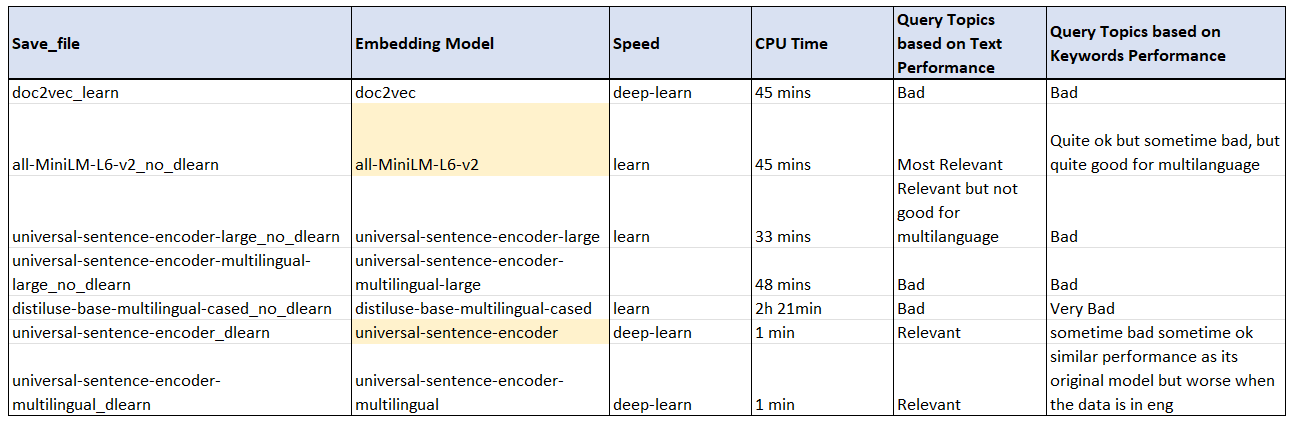

In [ ]:
%%time
# Example of creating and saving a top2vec model
np.random.seed(47)
model = Top2Vec(documents=list(esco_skill['skill_data']), embedding_model='doc2vec', ngram_vocab=True, use_embedding_model_tokenizer=True, speed='deep-learn')
model.save("doc2vec_learn")

2022-05-10 21:25:28,864 - top2vec - INFO - Pre-processing documents for training
2022-05-10 21:25:30,067 - top2vec - INFO - Creating joint document/word embedding


In [8]:
# Different embedding models
doc2vec_md = Top2Vec.load("Models/doc2vec_learn")
dbm_md = Top2Vec.load("Models/distiluse-base-multilingual-cased_no_dlearn")
usel_md = Top2Vec.load("Models/universal-sentence-encoder-large_no_dlearn")
useml_md = Top2Vec.load("Models/universal-sentence-encoder-multilingual-large_no_dlearn")
usem_md = Top2Vec.load("Models/universal-sentence-encoder-multilingual_dlearn")
use_md = Top2Vec.load("Models/universal-sentence-encoder_dlearn")
amlm_md = Top2Vec.load("Models/all-MiniLM-L6-v2_no_dlearn")

## Experiments Playground

### 1. Extract model info

In [9]:
def extract_model_info(model):
    total_topics = model.get_num_topics()
    total_vocab = len(model.vocab)
    topic_sizes, topic_nums = model.get_topic_sizes()
    topic_words, word_scores, topic_nums = model.get_topics()
    model_info = pd.DataFrame({'Topic Index':topic_nums, 'No. of Doc': topic_sizes, 'Topic Words': [x for x in topic_words], 'Word Scores': [x for x in word_scores]})
    return total_topics, total_vocab, model_info

In [10]:
extract_model_info(amlm_md)[:2]

(133, 8598)

In [11]:
extract_model_info(amlm_md)[2]

Topic Index  No. of Doc  \
0              0         349   
1              1         274   
2              2         268   
3              3         263   
4              4         260   
..           ...         ...   
128          128          32   
129          129          32   
130          130          32   
131          131          26   
132          132          23   

                                           Topic Words  \
0    [inspecting inspect, inspection reports, inspe...   
1    [artistic production, performing arts, choreog...   
2    [staff supervise, supervise, staff training, s...   
3    [veterinary setting, veterinary specialised, a...   
4    [advise customers, advise customer, advising c...   
..                                                 ...   
128  [pipeline infrastructure, pipeline projects, p...   
129  [learning platform, learning environments, vir...   
130  [welding techniques, welding, gas welding, arc...   
131  [oil well, water wells, drainage well, oil wel...   
132  [mechanical clocks, engineering watches, clock...   

                                           Word Scores  
0    [0.59666795, 0.5912153, 0.5900377, 0.5882613, ...  
1    [0.61416894, 0.59737945, 0.58904004, 0.5711806...  
2    [0.7053933, 0.5876641, 0.5799546, 0.55884856, ...  
3    [0.6002134, 0.5793154, 0.57768536, 0.5760894, ...  
4    [0.4940064, 0.490937, 0.47178194, 0.46826524, ...  
..                                                 ...  
128  [0.7753358, 0.7376175, 0.7170327, 0.7122685, 0...  
129  [0.6566708, 0.61466455, 0.6002265, 0.5378432, ...  
130  [0.76853013, 0.71035075, 0.66982055, 0.6540639...  
131  [0.55780417, 0.50713706, 0.47582412, 0.4586014...  
132  [0.5983426, 0.59136856, 0.58663577, 0.56443155...  

[133 rows x 4 columns]

### 2. Find courses based on specific topic

In [12]:
# Find courses under specific topic:
def course_search_based_on_topic(topic):
    ind_list = []
    for row in range(len(df['topics_list'])):
        if topic in df['topics_list'][row]:
            ind_list.append(row)
    return df.iloc[ind_list]

In [13]:
course_search_based_on_topic('python').index

Int64Index([ 1076,  1162,  1163,  1322,  1346,  1434,  1435,  1436,  1438,
             2048,
            ...
            78244, 78289, 78305, 78365, 78369, 78373, 78374, 78597, 78732,
            78793],
           dtype='int64', length=785)

In [14]:
index = 1163
print('title: ', df['title'][index])
print('tags: ', df['tags'][index])
print('topics: ', df['topics'][index])
print('description: ', df['description'][index])

title:  A Note on Using Financial Data in Python
tags:  it skills, python, finance, business skills
topics:  technology skills, programming and web development, python
description:    Course Overview   Do you want to learn how to use Python in a working environment? Are you a young professional interested in a career in Data Science? Would you like to explore how Python can be applied in the world of Finance and solve portfolio optimization problems? If so, then this is the right course for you!    Target Audience    Aspiring data scientists   Programming beginners  People interested in finance and investments   Programmers who want to specialize in finance   Everyone who wants to learn how to code and apply their skills in practice   Finance graduates and professionals who need to better apply their knowledge in Python    This video is part of the course  Python for Finance  Investment Fundamentals and Data Analytics  


### 3. Query Skill Topics based on Course Data

In [15]:
query = df['course_data'][index]
query

'A Note on Using Financial Data in Python technology skills, programming and web development, python it skills, python, finance, business skills   Course Overview   Do you want to learn how to use Python in a working environment? Are you a young professional interested in a career in Data Science? Would you like to explore how Python can be applied in the world of Finance and solve portfolio optimization problems? If so, then this is the right course for you!    Target Audience    Aspiring data scientists   Programming beginners  People interested in finance and investments   Programmers who want to specialize in finance   Everyone who wants to learn how to code and apply their skills in practice   Finance graduates and professionals who need to better apply their knowledge in Python    This video is part of the course  Python for Finance  Investment Fundamentals and Data Analytics  '

0.43902612
0.35058668
0.331533
0.32205567
0.31827655


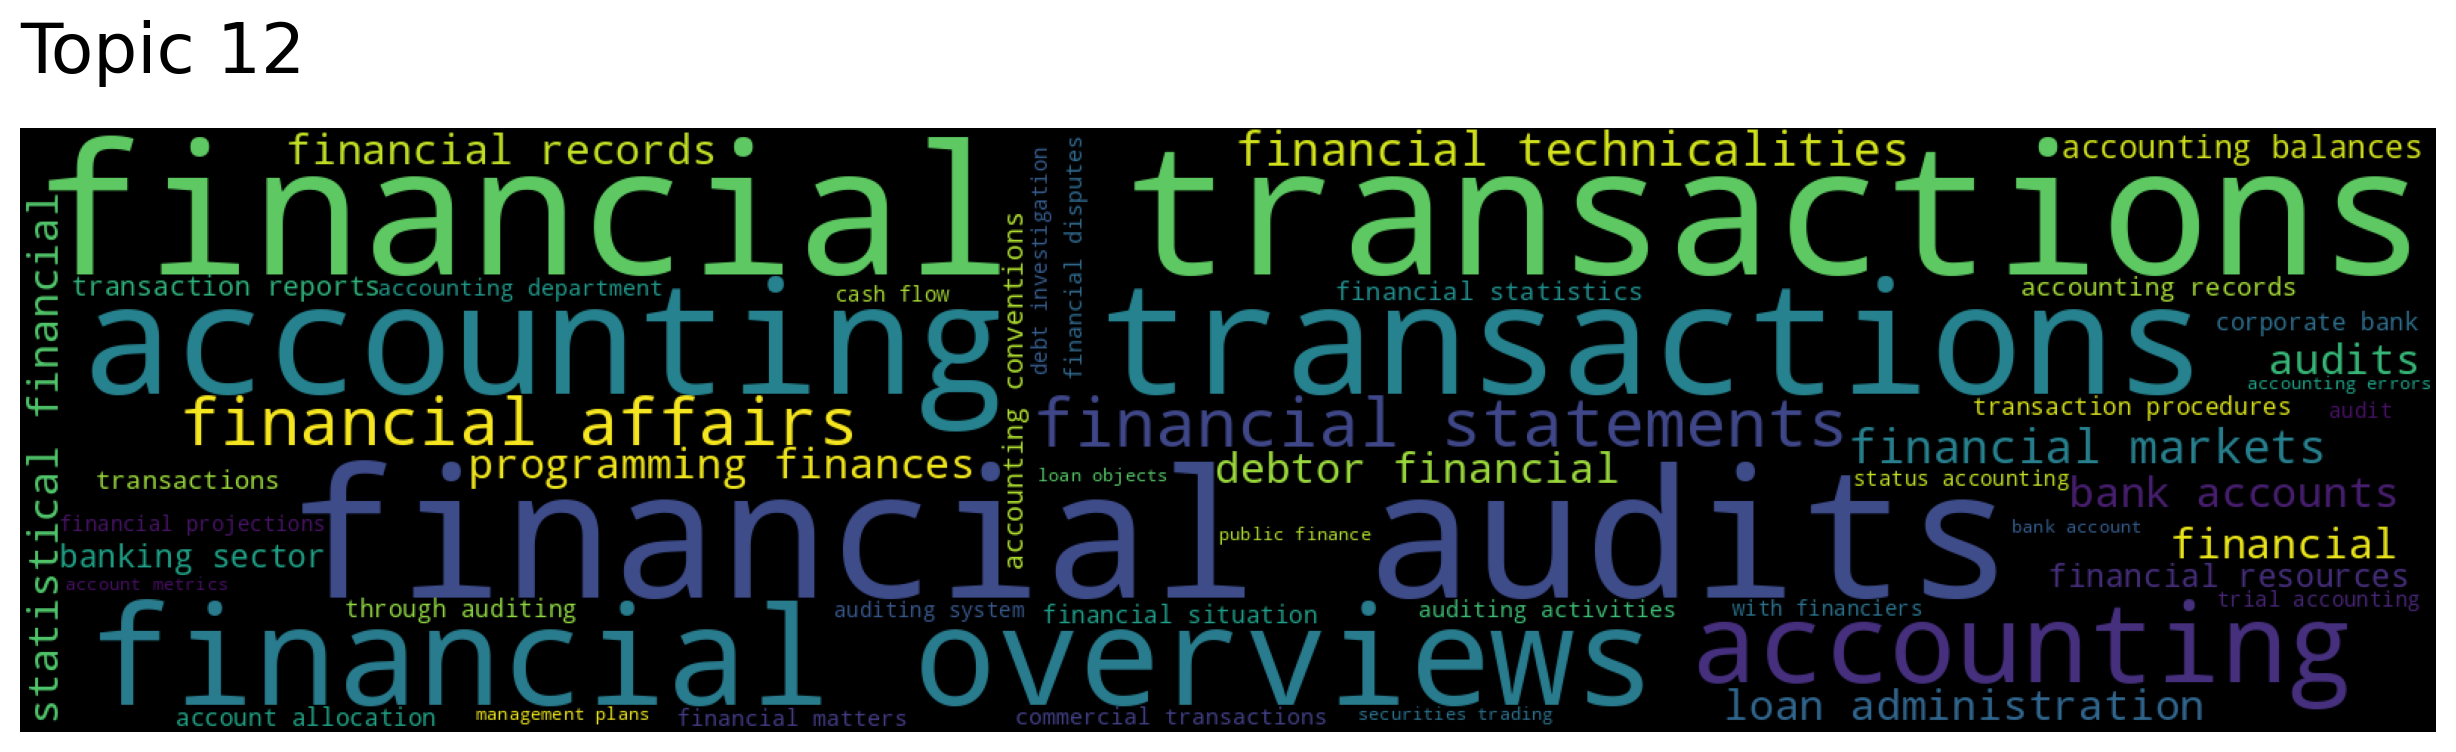

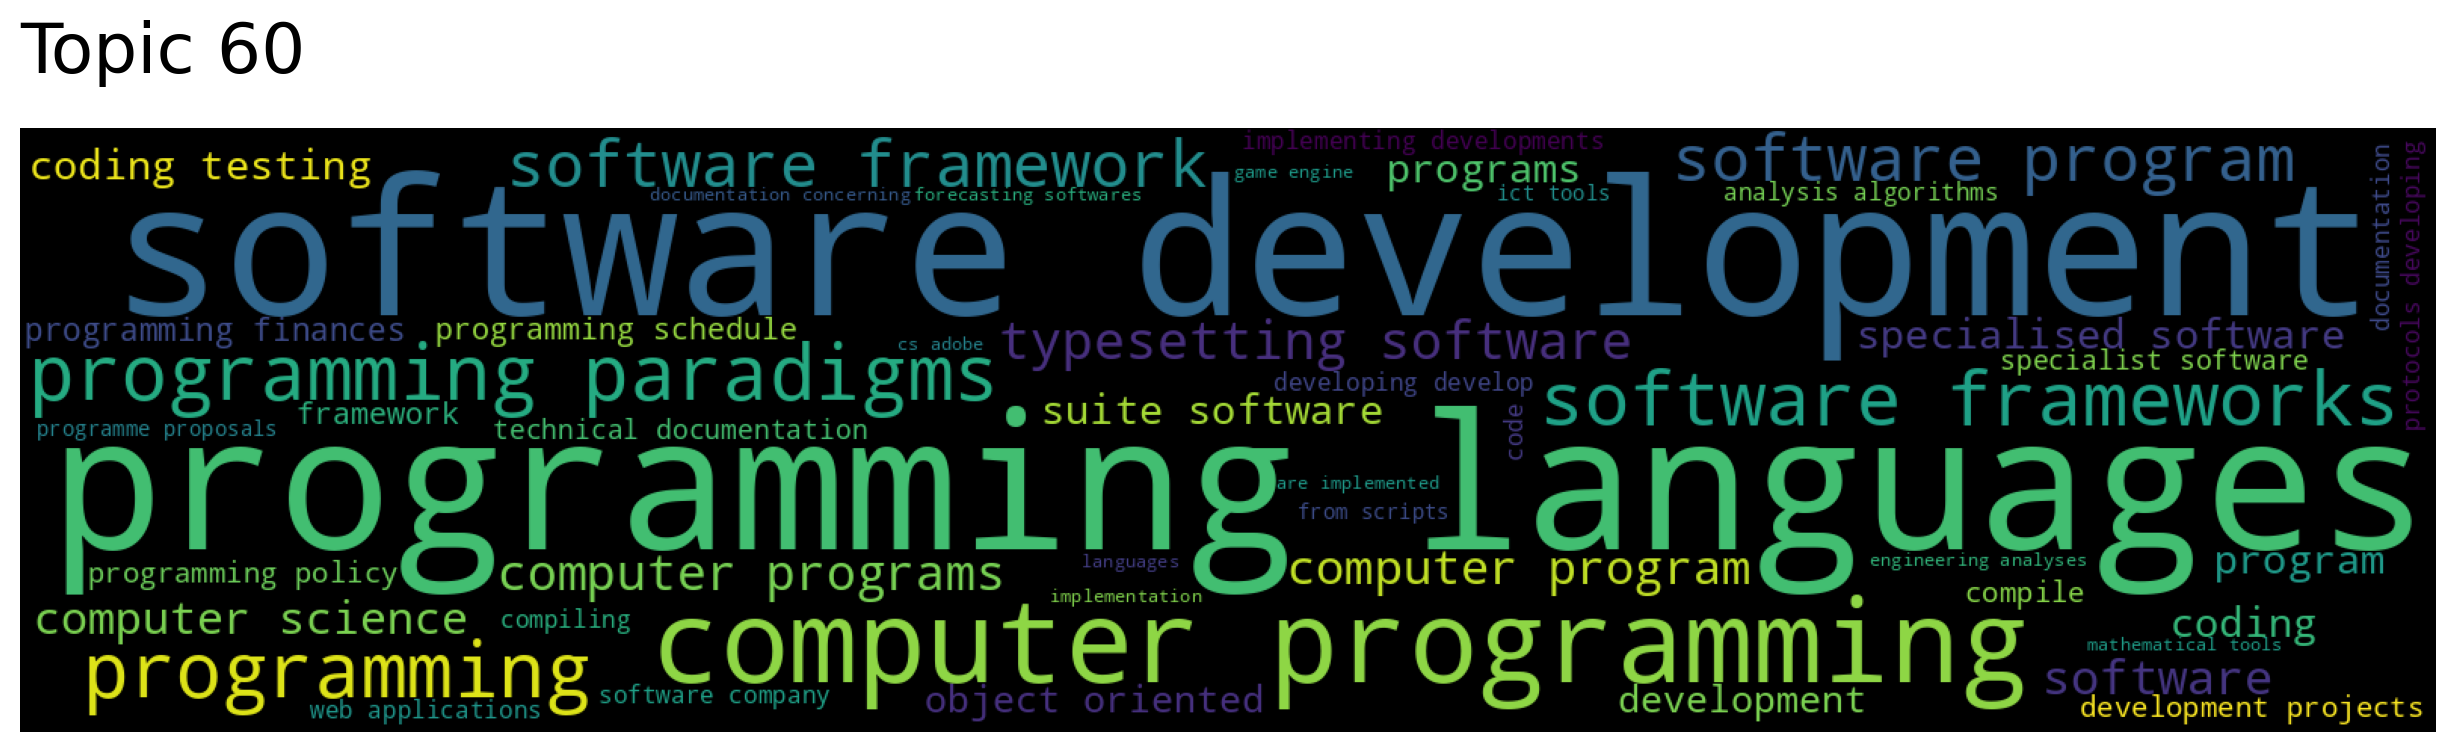

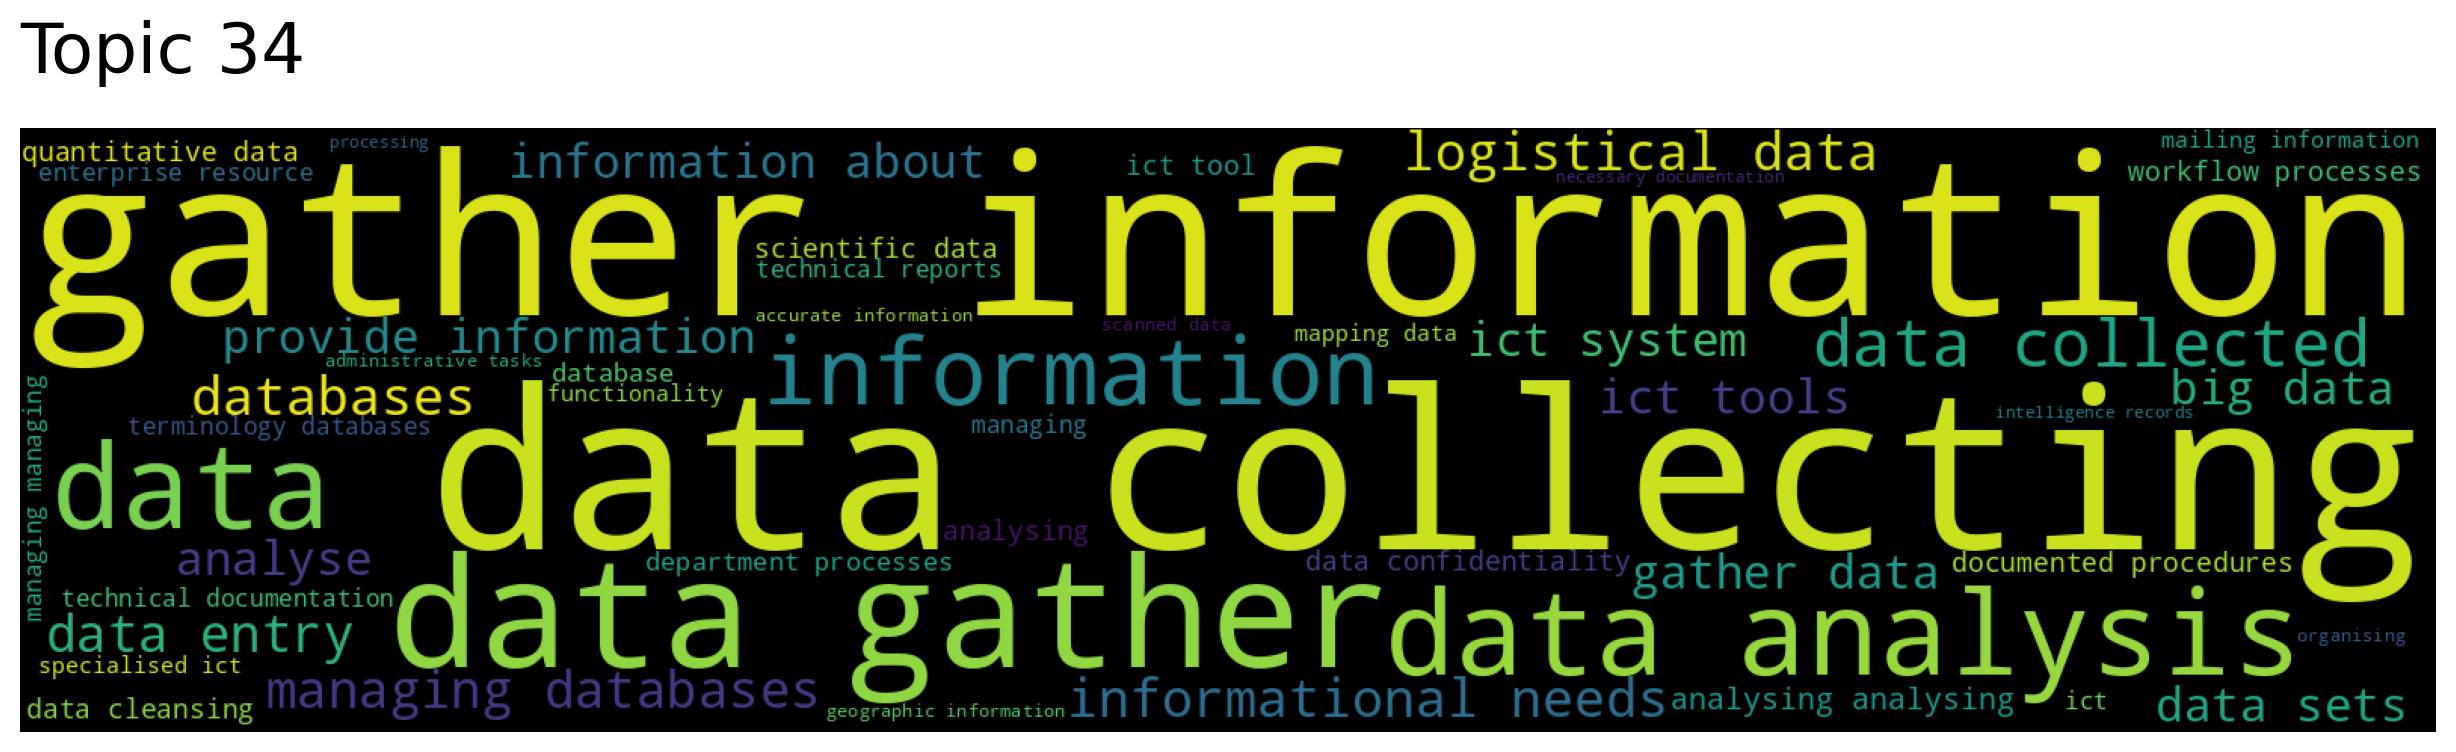

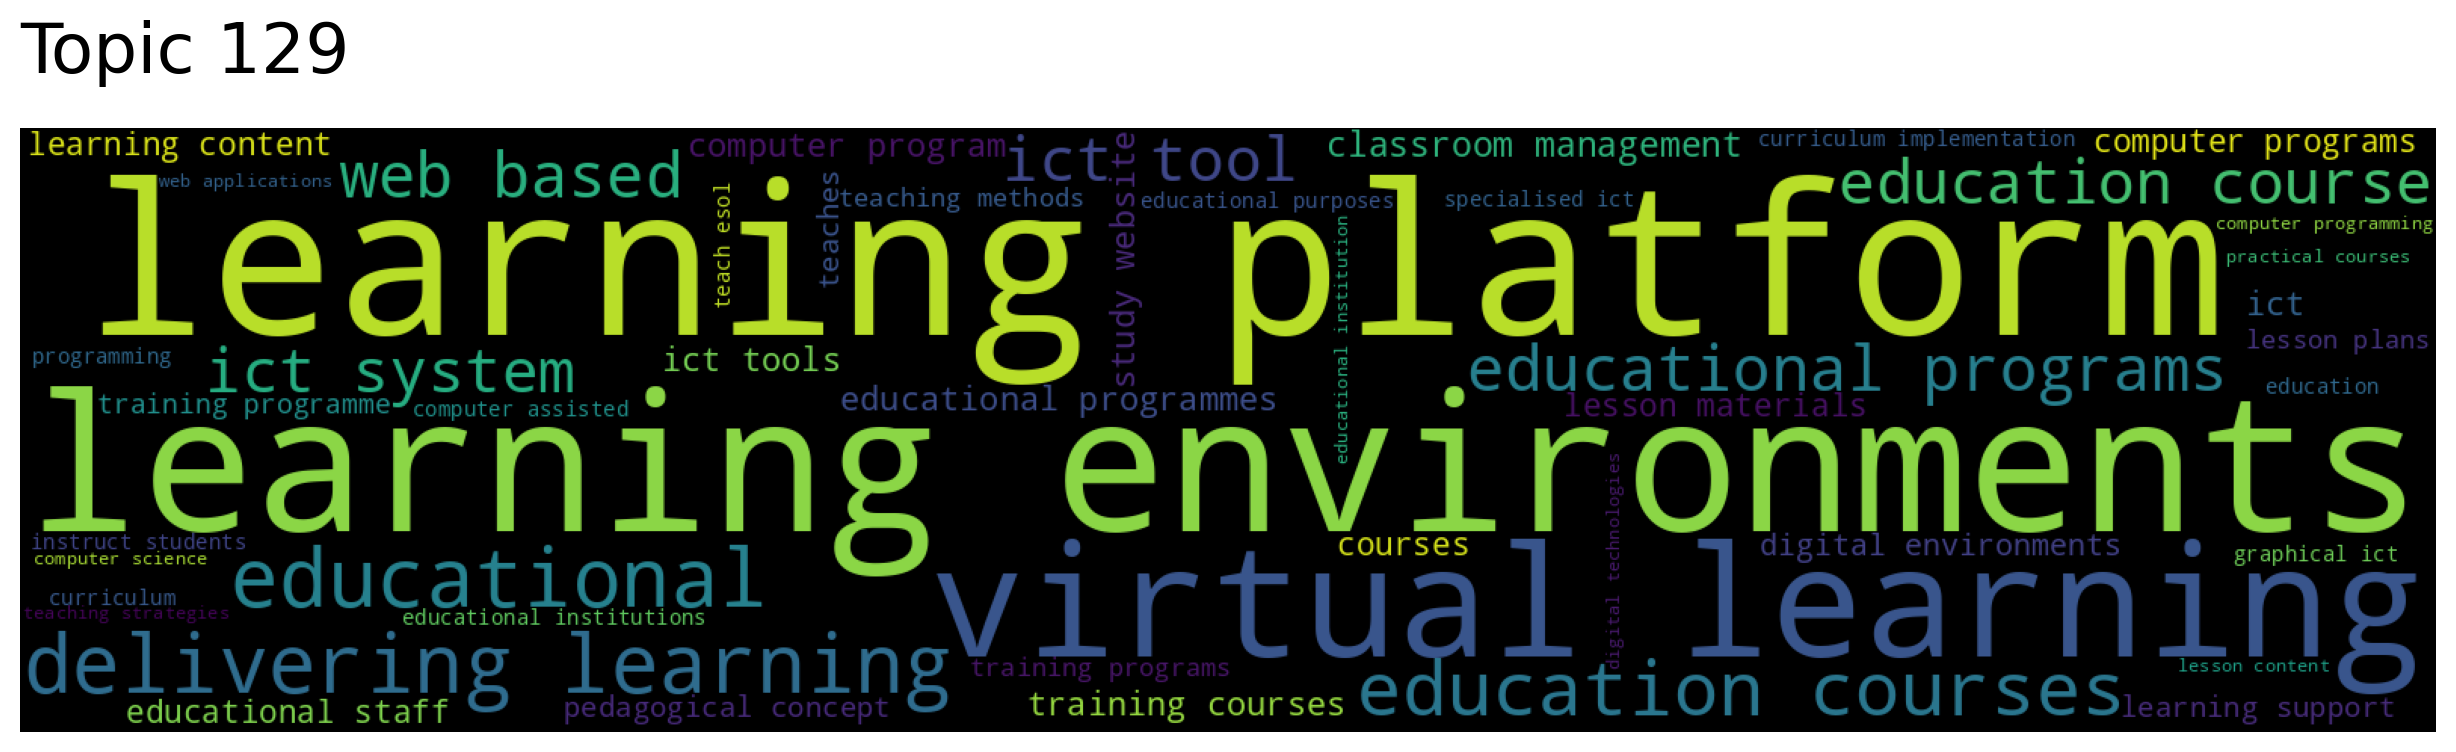

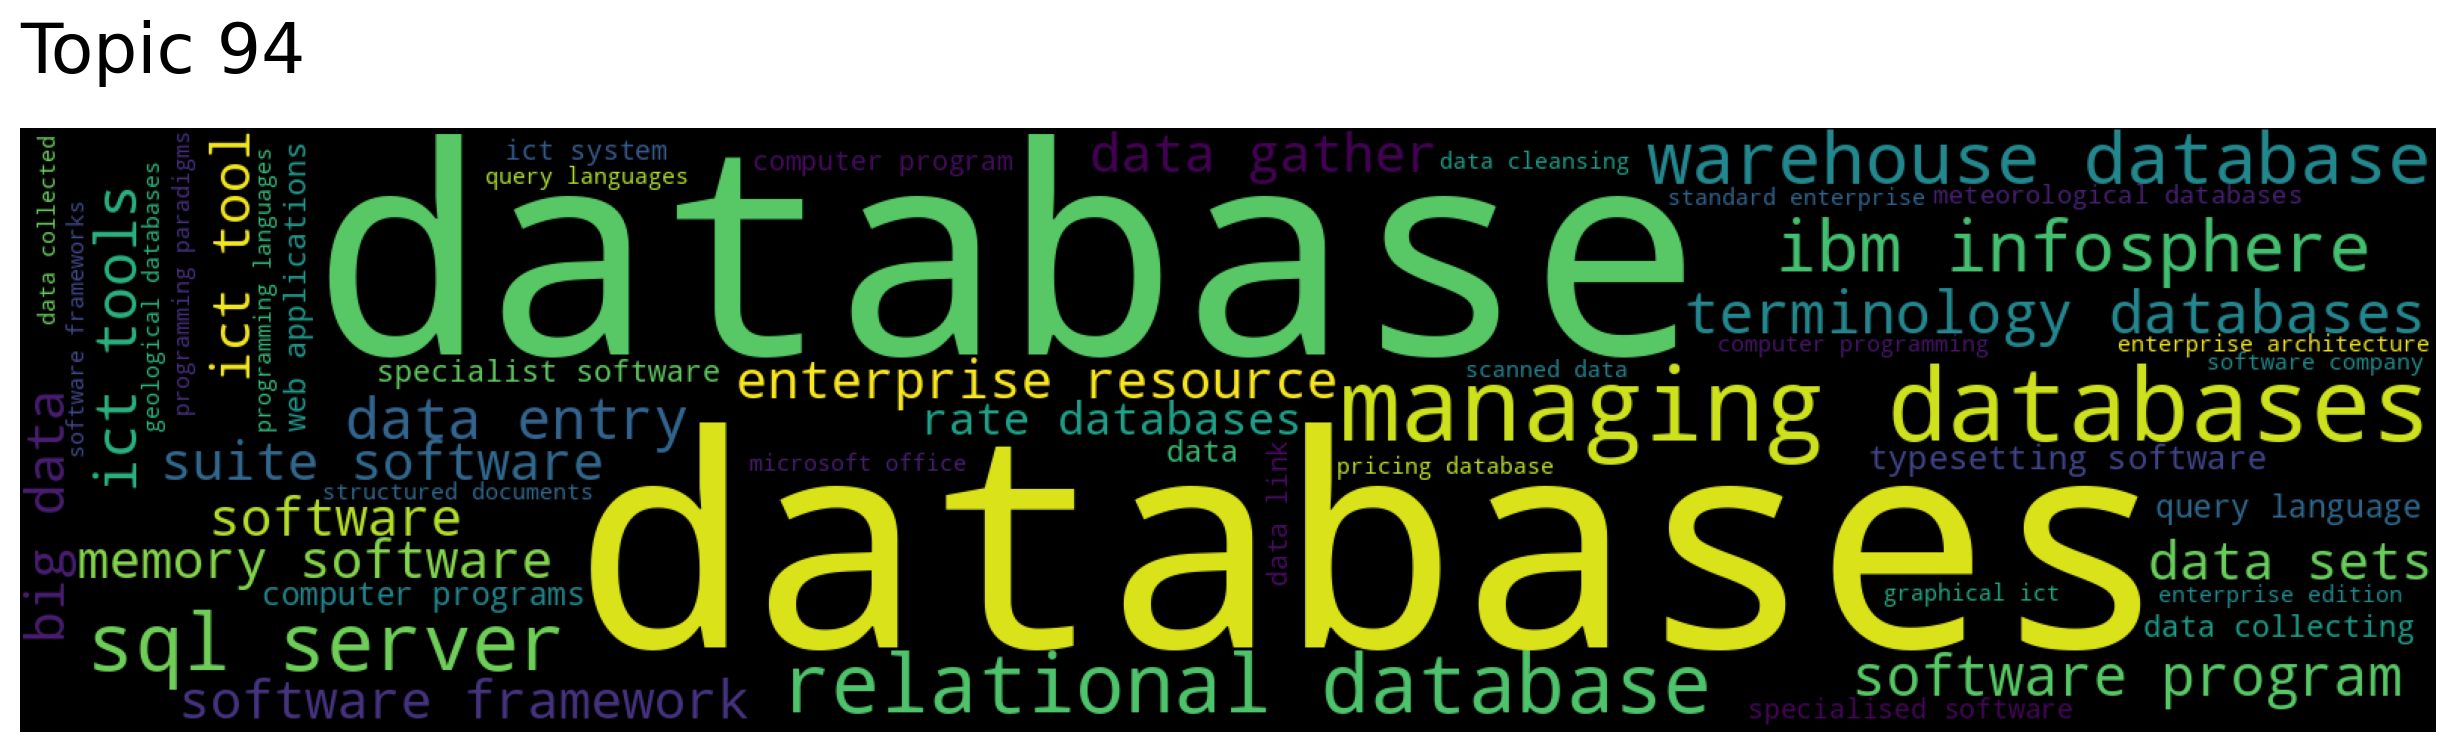

In [16]:
model = amlm_md
topic_words, word_scores, topic_scores, topic_nums = model.query_topics(query, num_topics=5, reduced=False, tokenizer=None)

for r in range(len(topic_nums)):
    print(topic_scores[r])
    model.generate_topic_wordcloud(topic_nums[r])

### 4. Query Skill Topics based on Course Data's Keywords which appeared in Model Vocab

In [17]:
import spacy
from spacy.matcher import PhraseMatcher
nlp = spacy.load("en_core_web_sm")

matcher = PhraseMatcher(nlp.vocab, attr="LOWER")
terms = list(model.vocab)

# Only run nlp.make_doc to speed things up
patterns = [nlp.make_doc(text) for text in terms]
matcher.add("TerminologyList_Skill", patterns)

doc = nlp(df['course_data'][index])
matches = matcher(doc)

keywords_match = []
for match_id, start, end in matches:
    span = doc[start:end]
    keywords_match.append(span.text)

In [18]:
str(keywords_match)

"['on', 'Using', 'Financial', 'Data', 'in', 'technology', 'skills', 'programming', 'and', 'web', 'development', 'it', 'skills', 'business', 'skills', 'Course', 'Do', 'to', 'how', 'to', 'use', 'in', 'working', 'working environment', 'environment', 'Are', 'young', 'professional', 'in', 'career', 'in', 'Data', 'Science', 'like', 'to', 'how', 'can', 'can be', 'be', 'be applied', 'applied', 'in', 'the', 'of', 'and', 'solve', 'problems', 'If', 'so', 'this', 'is', 'the', 'right', 'course', 'for', 'Target', 'Target Audience', 'Audience', 'data', 'Programming', 'People', 'in', 'and', 'who', 'to', 'in', 'who', 'to', 'how', 'to', 'code', 'and', 'apply', 'their', 'skills', 'in', 'practice', 'and', 'professionals', 'who', 'need', 'to', 'apply', 'their', 'knowledge', 'in', 'This', 'video', 'is', 'part', 'of', 'the', 'course', 'for', 'Investment', 'Fundamentals', 'and', 'Data']"

0.2961041083321406
0.29021375221322604
0.2850109735470623
0.28029073934300053
0.26192528419374


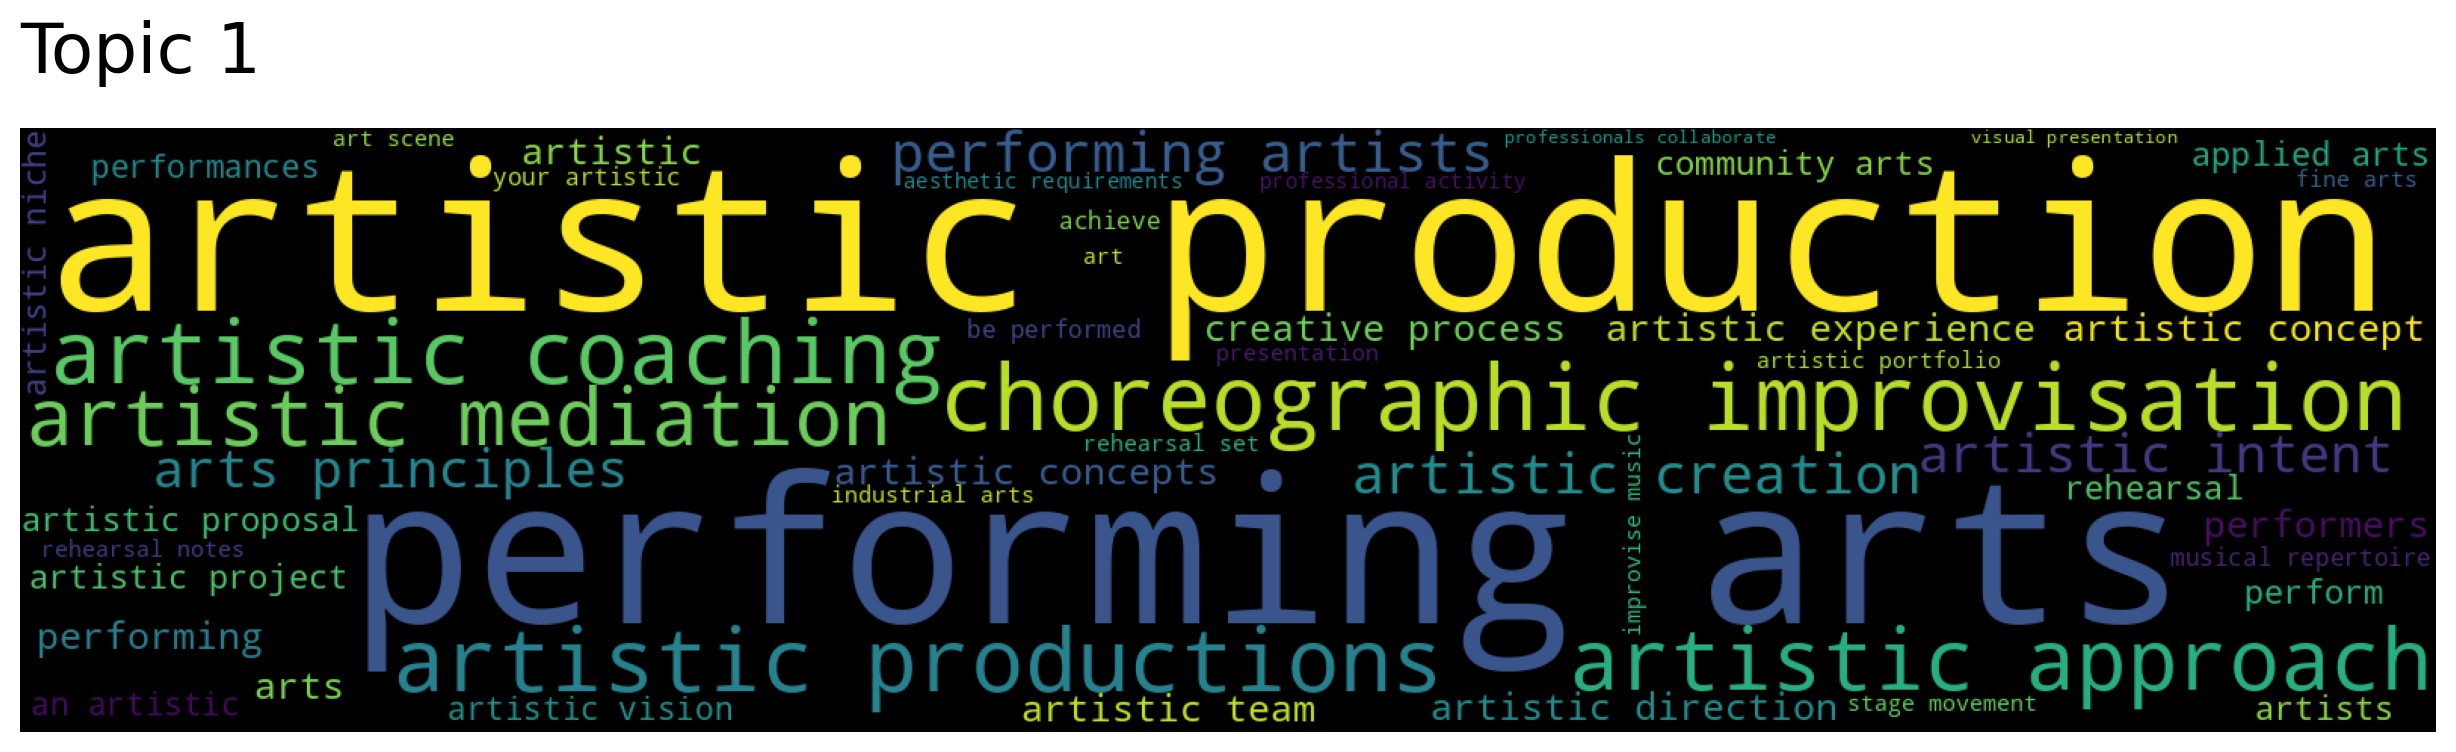

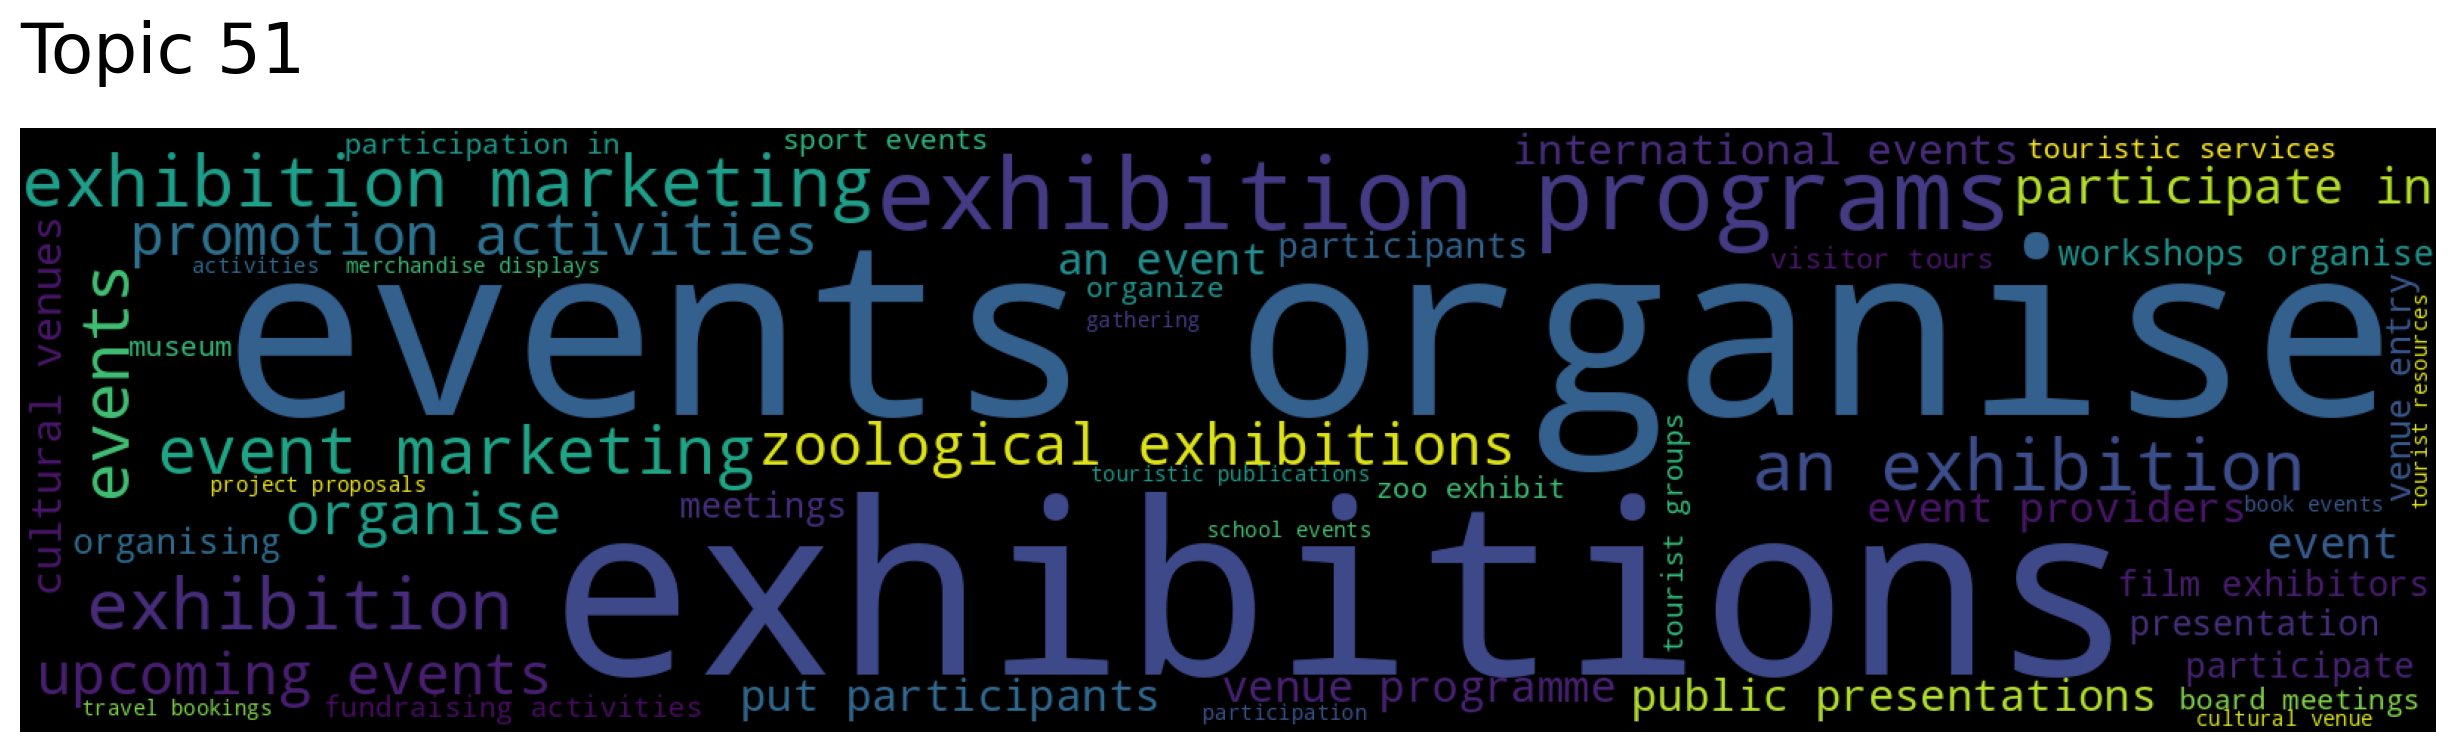

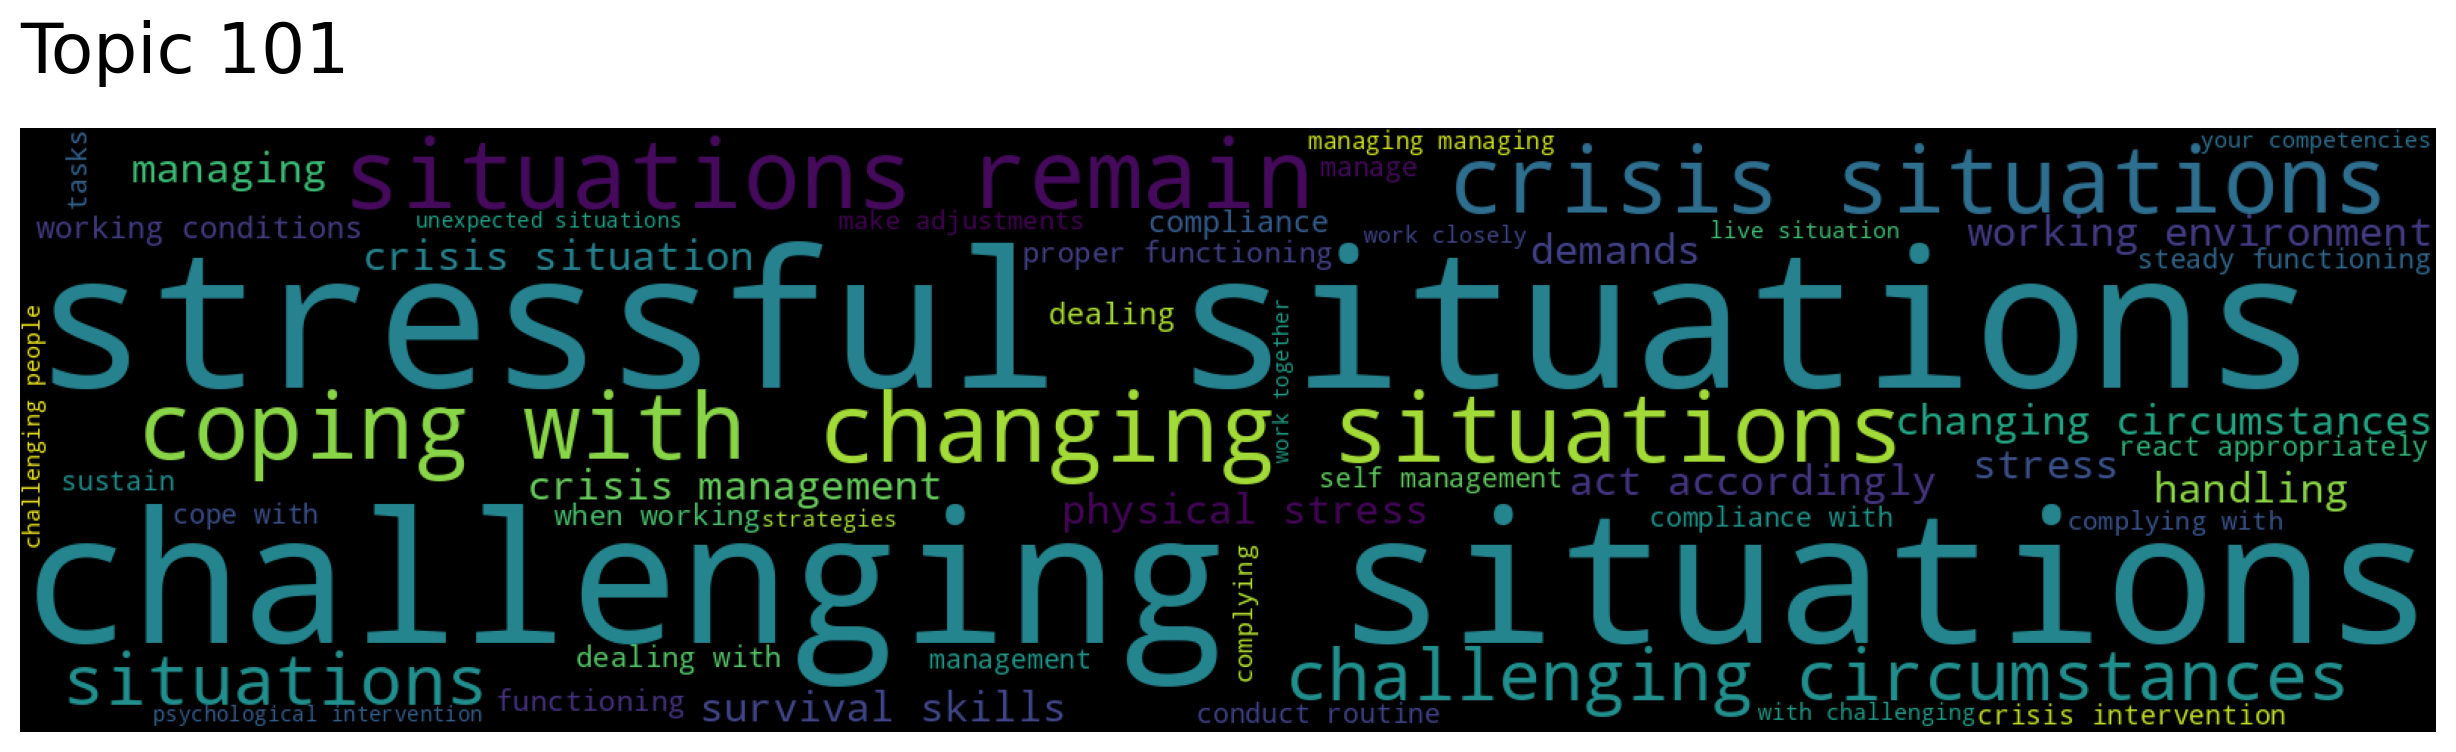

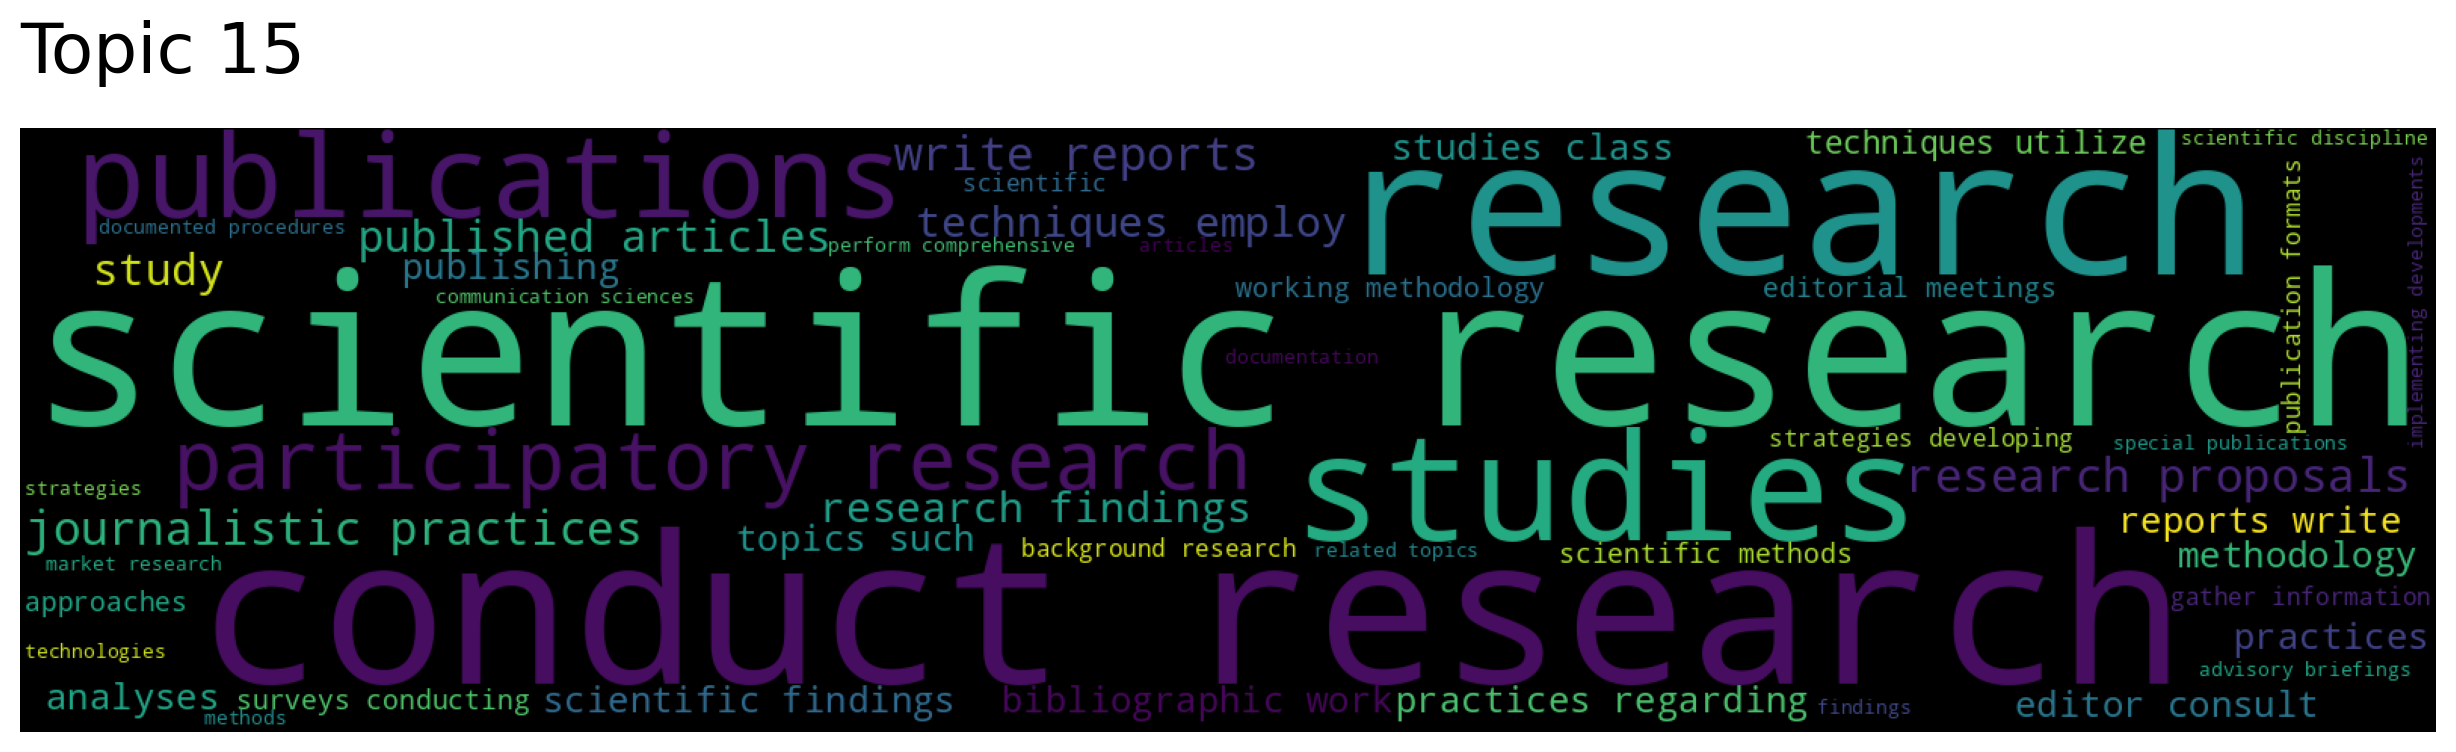

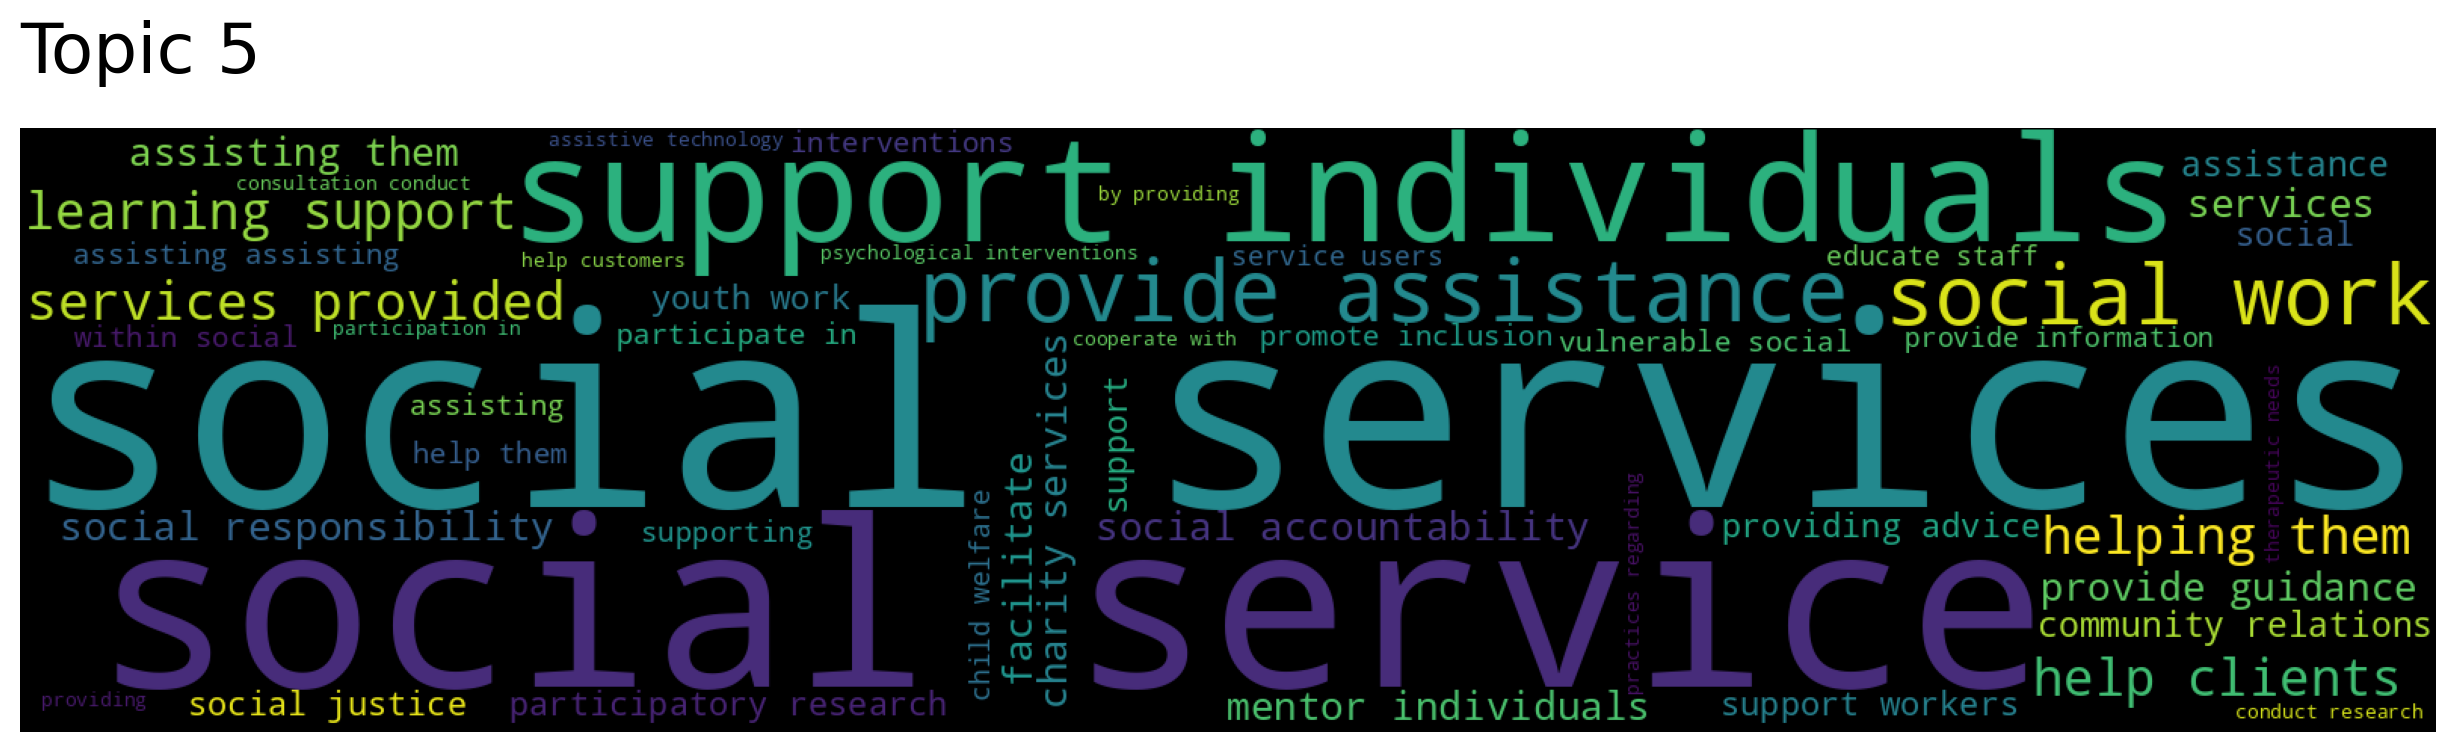

In [19]:
topic_words, word_scores, topic_scores, topic_nums = model.search_topics(keywords=keywords_match, num_topics=5)

for r in range(len(topic_nums)):
    print(topic_scores[r])
    model.generate_topic_wordcloud(topic_nums[r])

### 5. Combine Search

In [20]:
_, _, topic_scores_qt, topic_nums_qt = model.query_topics(query, num_topics=5, reduced=False, tokenizer=None)
_, _, topic_scores_st, topic_nums_st = model.search_topics(keywords=keywords_match, num_topics=5)

In [21]:
cmb_search_df = pd.DataFrame({'Topic Number': list(topic_nums_qt) +  list(topic_nums_st), 'Topic Relevancy': list(topic_scores_qt) +  list(topic_scores_st)})
cmb_search_df = (cmb_search_df.sort_values(by='Topic Relevancy', ascending=False) \
                              .drop_duplicates(subset ="Topic Number"))
cmb_search_df

Topic Number  Topic Relevancy
0            12         0.439026
1            60         0.350587
2            34         0.331533
3           129         0.322056
4            94         0.318277
5             1         0.296104
6            51         0.290214
7           101         0.285011
8            15         0.280291
9             5         0.261925

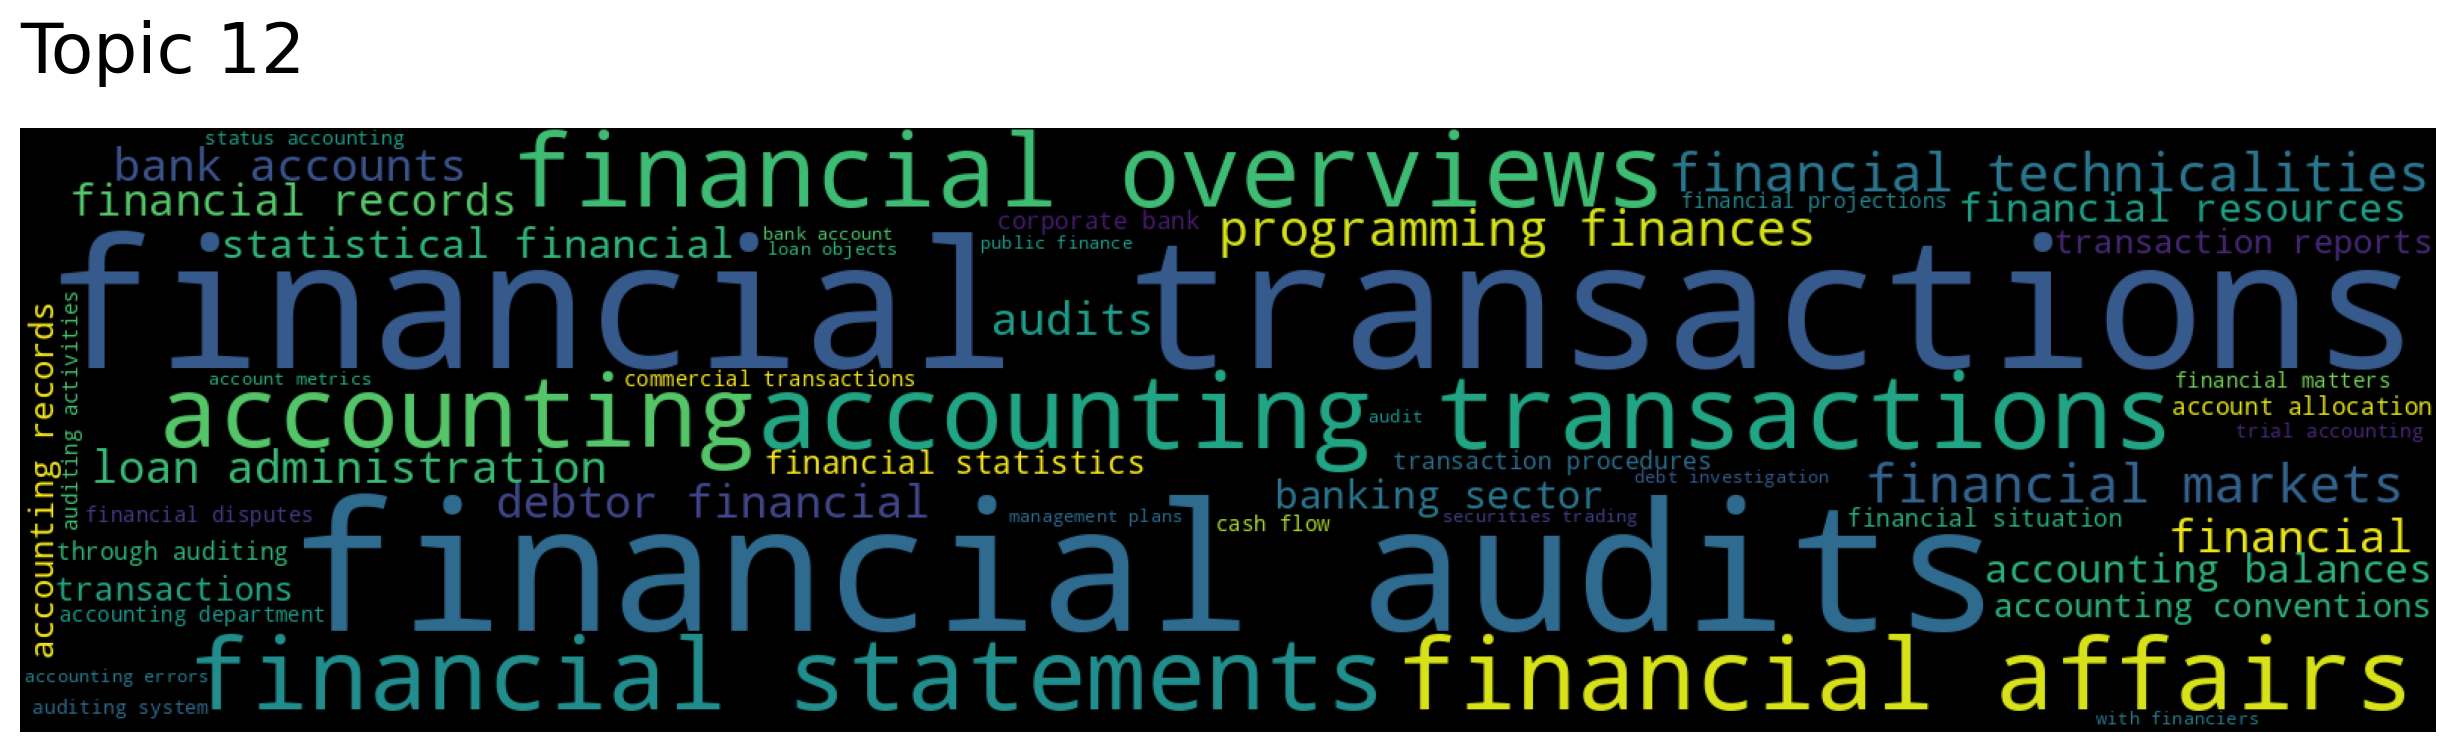

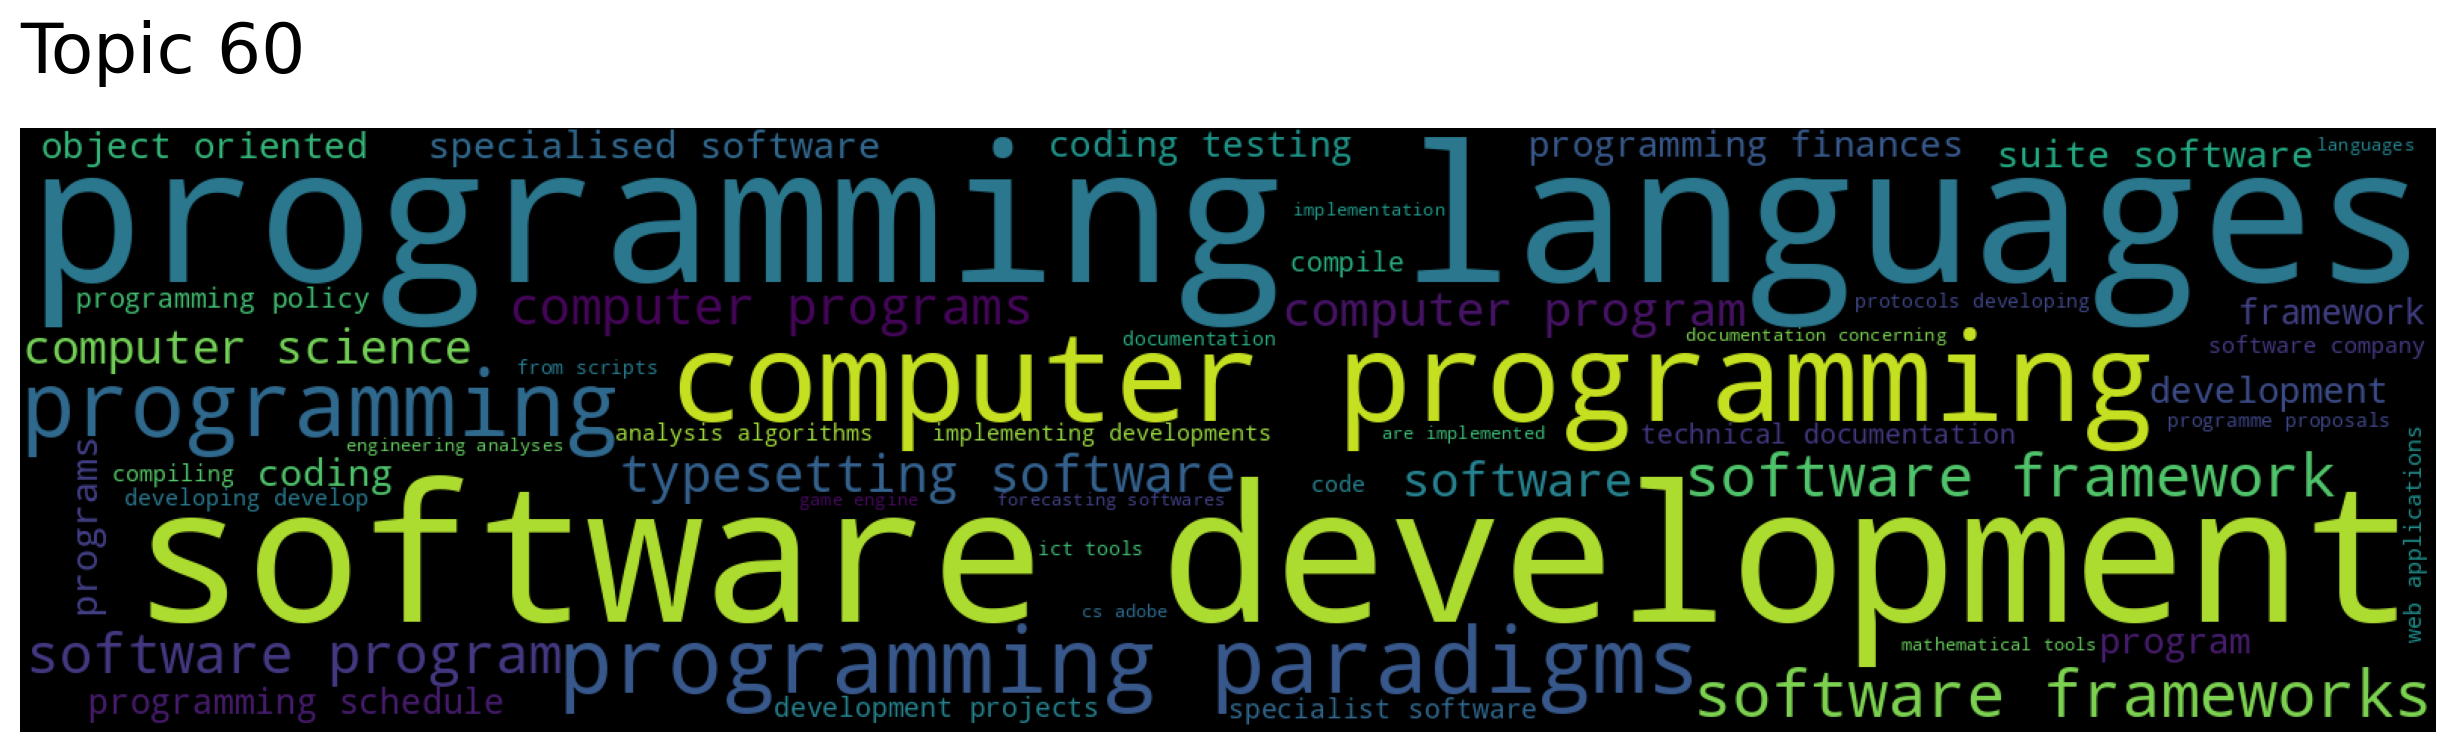

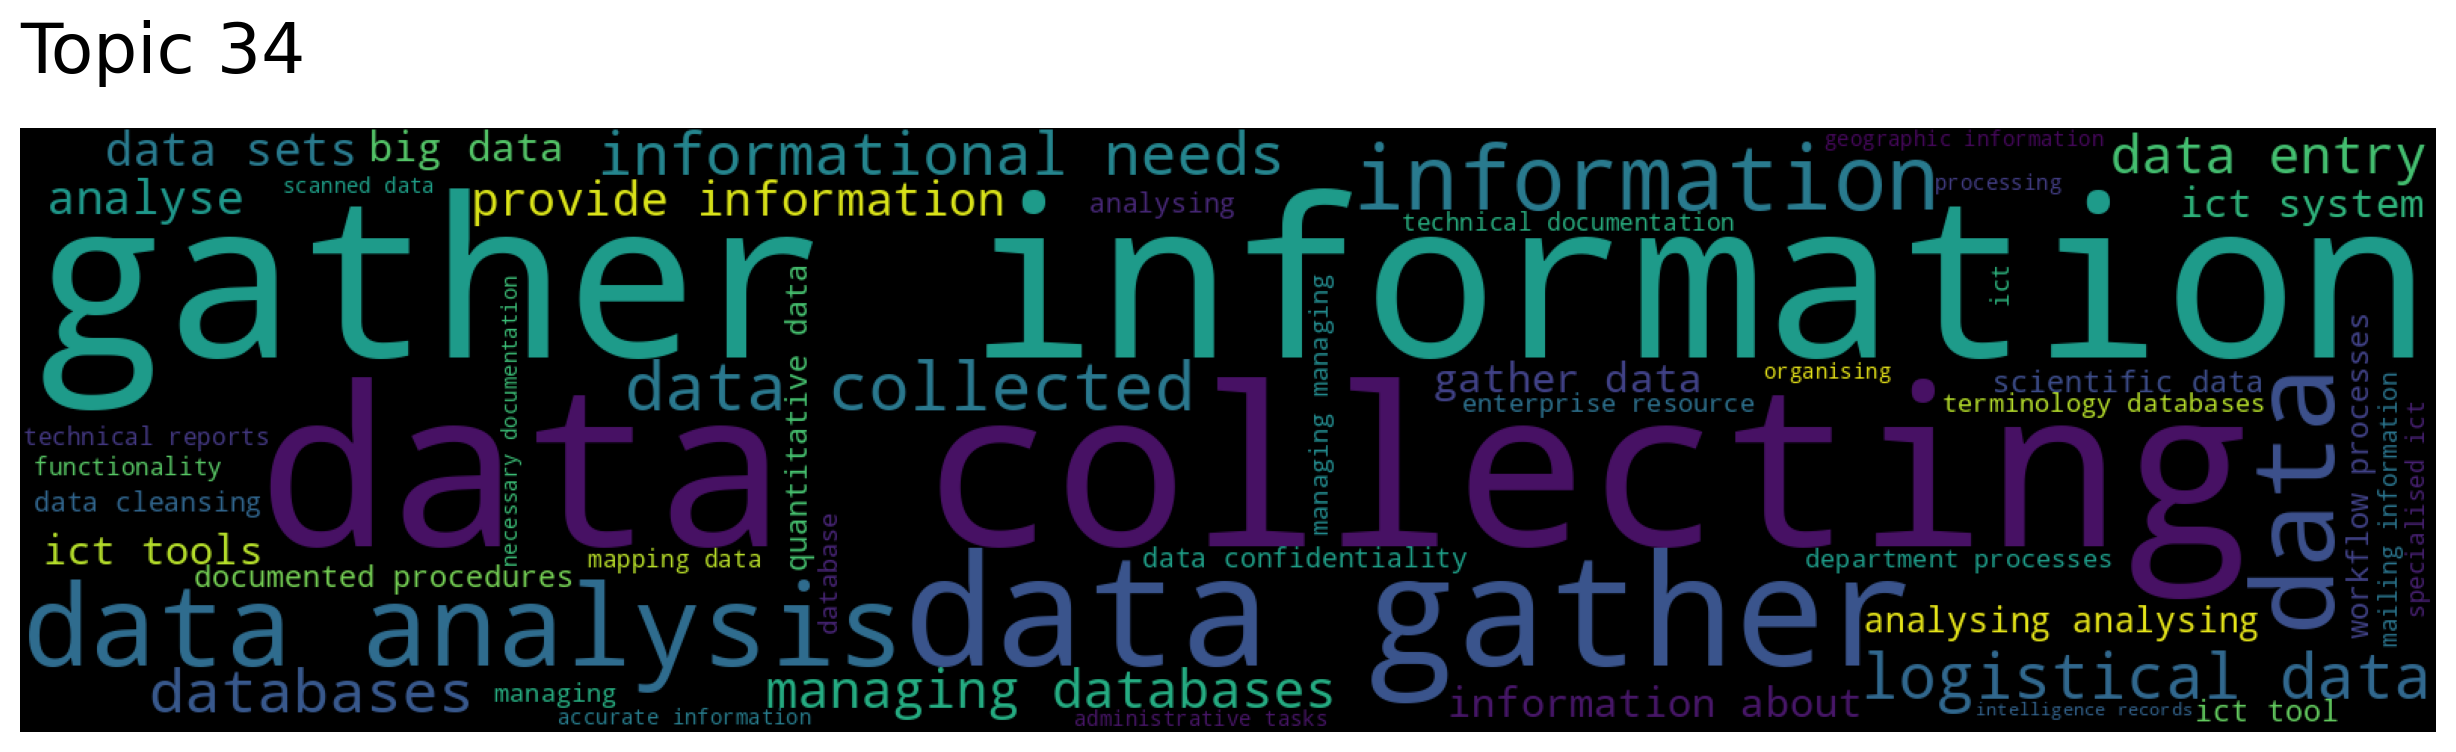

In [22]:
# Get the Top 3 Topics based on Combine Search
topic_nums_list = cmb_search_df['Topic Number'][:3]
for r in topic_nums_list:
    model.generate_topic_wordcloud(r)

In [23]:
model_info = extract_model_info(amlm_md)[2]
doc_ids = []
for elem in topic_nums_list:
    _, _, document_ids = model.search_documents_by_topic(topic_num = elem, num_docs = int(model_info[model_info['Topic Index']==elem]['No. of Doc'].values))
    doc_ids.append(document_ids)
doc_ids = [elem for array in doc_ids for elem in array]
len(doc_ids)

426

# Next Section: Build the Skill-Course Relation Data

In [24]:
import spacy
from spacy.matcher import PhraseMatcher
nlp = spacy.load("en_core_web_sm")

matcher = PhraseMatcher(nlp.vocab, attr="LOWER")
terms = list(model.vocab)

# Only run nlp.make_doc to speed things up
patterns = [nlp.make_doc(text) for text in terms]
matcher.add("TerminologyList_Skill", patterns)

In [25]:
def query_skill_topics_based_on_course_text(model,index):
    query = df['course_data'][index]
    _, _, topic_scores_qt, topic_nums_qt = model.query_topics(query, num_topics=5, reduced=False, tokenizer=None)
    return topic_scores_qt, topic_nums_qt

def query_skill_topics_based_on_keywords(model,keywords_match):
    _, _, topic_scores_st, topic_nums_st = model.search_topics(keywords=keywords_match, num_topics=5)
    return topic_scores_st, topic_nums_st

def combine_search(topic_scores_qt, topic_nums_qt, topic_scores_st, topic_nums_st):
    cmb_search_df = pd.DataFrame({'Topic Number': list(topic_nums_qt) +  list(topic_nums_st), 'Topic Relevancy': list(topic_scores_qt) +  list(topic_scores_st)})
    cmb_search_df = (cmb_search_df.sort_values(by='Topic Relevancy', ascending=False) \
                              .drop_duplicates(subset ="Topic Number"))
    topic_nums_list = cmb_search_df['Topic Number'][:3]
    return topic_nums_list

def get_corresponding_skill_id(model, topic_nums_list):
    model_info = extract_model_info(model)[2]
    doc_ids = []
    for elem in topic_nums_list:
        _, _, document_ids = model.search_documents_by_topic(topic_num = elem, num_docs = int(model_info[model_info['Topic Index']==elem]['No. of Doc'].values))
        doc_ids.append(document_ids)
    doc_ids = [elem for array in doc_ids for elem in array]
    return doc_ids

def skill_course_relation(index, doc_ids):
    course = pd.Series([df['id'][index]]*len(doc_ids), name="Course Id")
    esco = esco_skill[['conceptUri','preferredLabel']].iloc[doc_ids].reset_index()
    s_c_data = pd.concat([esco,course], axis=1)
    return s_c_data

In [ ]:
%%time
z = pd.DataFrame()
for i in range(len(df)):
    # course_data
    doc = nlp(df['course_data'][i])
    matches = matcher(doc)
    
    keywords_match = []
    for match_id, start, end in matches:
        span = doc[start:end]
        keywords_match.append(span.text)
        
        # Only continue if course_keywords appear in model_vocab
        if len(keywords_match)==0:
            continue
            
        topic_nums_list = combine_search(query_skill_topics_based_on_course_text(model,i)[0], 
                                         query_skill_topics_based_on_course_text(model,i)[1], 
                                         query_skill_topics_based_on_keywords(model, keywords_match)[0], 
                                         query_skill_topics_based_on_keywords(model, keywords_match)[1])
        s_c_data = skill_course_relation(i, get_corresponding_skill_id(model, topic_nums_list))
    z = pd.concat([z,s_c_data],axis=0)

In [134]:
len(z)

index                                         conceptUri  \
0     6698  http://data.europa.eu/esco/skill/7a147904-22b3...   
1     9171  http://data.europa.eu/esco/skill/a8460be3-f4ba...   
2     4017  http://data.europa.eu/esco/skill/49e1eb78-e6b1...   
3     6709  http://data.europa.eu/esco/skill/7a66b8a3-502f...   
4     1002  http://data.europa.eu/esco/skill/12da3e83-57a6...   
..     ...                                                ...   
566   4210  http://data.europa.eu/esco/skill/4d5a2c88-bfbc...   
567   9277  http://data.europa.eu/esco/skill/aa56a80c-b4d5...   
568   2263  http://data.europa.eu/esco/skill/294cf13e-4fdf...   
569   8989  http://data.europa.eu/esco/skill/a4d0e4df-28c0...   
570   3794  http://data.europa.eu/esco/skill/45a5c216-2ecc...   

                                        preferredLabel  Course Id  
0                                     cope with stress   28398490  
1                          handle stressful situations   28398490  
2                 react calmly in stressful situations   28398490  
3     deal with pressure from unexpected circumstances   28398490  
4    cope with challenging circumstances in the vet...   28398490  
..                                                 ...        ...  
566                             comparative literature    8569489  
567                                           rhetoric    8569489  
568                                              logic    8569489  
569            listen to the stories of the disputants    8569489  
570                                 literary criticism    8569489  

[1026 rows x 4 columns]